# Tutorial 6 — From Market News to Quantitative Signals

## Overview

News drives short-term price discovery.  Earnings surprises, analyst upgrades,
product launches, and regulatory actions all generate **discrete information
shocks** that can be mapped to trading signals.

This tutorial shows how to:
1. Generate and structure synthetic news/event data.
2. Aggregate event-level data into daily cross-sectional signals.
3. Conduct an **event study** to measure the price impact of news.
4. Apply **exponential decay** to model fading information content.
5. Build and backtest three news-based strategies (momentum, reversal,
   volatility avoidance).
6. Combine news signals with price-based momentum.
7. Understand backtesting pitfalls specific to event-driven strategies.

> **Data note**: Price data is real (via yfinance).  News data is entirely
> *synthetic* — generated programmatically — because no free, redistributable
> historical news corpus exists for the tickers and date range we use.

## 1. Setup and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams.update({"figure.figsize": (12, 5), "figure.dpi": 100,
                     "axes.grid": True, "grid.alpha": 0.3})

from qlab.data import YFinanceProvider, ParquetCache
from qlab.features import simple_returns, realized_volatility, rank, zscore
from qlab.features.rolling import rolling_mean, rolling_std
from qlab.portfolio import equal_weight_long_short, normalize_weights
from qlab.backtest import run_backtest, BacktestConfig
from qlab.risk import performance_summary, drawdown_series, drawdown_details

TICKERS = [
    "AAPL", "MSFT", "GOOG", "AMZN", "META",
    "JPM", "GS", "BAC",
    "JNJ", "PFE", "UNH",
    "XOM", "CVX",
    "PG", "KO", "WMT",
    "HD", "NKE",
    "CAT", "HON",
]
START, END = "2018-01-01", "2024-12-31"

provider = ParquetCache(YFinanceProvider(), cache_dir=".qlab_cache")
prices = provider.fetch(TICKERS, START, END)
close = prices["adj_close"]
ret = simple_returns(close)

trading_dates = close.index.get_level_values("date").unique().sort_values()
print(f"Universe : {close.index.get_level_values('ticker').nunique()} stocks")
print(f"Date range: {trading_dates.min().date()} to {trading_dates.max().date()}")
print(f"Total obs : {len(close):,}")
print(f"Trading days: {len(trading_dates):,}")

Universe : 20 stocks
Date range: 2018-01-02 to 2024-12-30
Total obs : 35,200
Trading days: 1,760


## 2. Generate synthetic news data

We create a realistic synthetic news dataset with the following properties:

- **~30 events per stock per year** (~4,200 total per year for the 20-stock universe).
- Events **cluster around quarterly earnings months** (Jan, Apr, Jul, Oct) to mimic real
  news flow.
- **Sentiment** ranges from -1 (very negative) to +1 (very positive) and follows
  a slightly positive-skewed distribution (reflecting the well-documented positivity
  bias in financial news).
- **Magnitude** in [0, 1] captures the importance of the event.
- **Category** labels: `earnings`, `analyst`, `product`, `regulatory`, `macro`, `other`.
- **Source** labels: `reuters`, `bloomberg`, `wsj`, `cnbc`, `other`.

In [2]:
def generate_synthetic_news(tickers, start, end, rng=None):
    """Generate a synthetic news DataFrame with realistic clustering properties.

    Parameters
    ----------
    tickers : list[str]
    start, end : str  (YYYY-MM-DD)
    rng : np.random.Generator, optional

    Returns
    -------
    pd.DataFrame with columns: timestamp, ticker, sentiment, magnitude, category, source
    """
    if rng is None:
        rng = np.random.default_rng(42)

    start_dt = pd.Timestamp(start)
    end_dt = pd.Timestamp(end)
    n_years = (end_dt - start_dt).days / 365.25
    events_per_stock_per_year = 30
    n_events_per_stock = int(events_per_stock_per_year * n_years)

    categories = ["earnings", "analyst", "product", "regulatory", "macro", "other"]
    cat_weights = np.array([0.20, 0.25, 0.15, 0.10, 0.15, 0.15])
    sources = ["reuters", "bloomberg", "wsj", "cnbc", "other"]
    src_weights = np.array([0.25, 0.25, 0.20, 0.15, 0.15])

    # Quarterly earnings months: Jan, Apr, Jul, Oct
    earnings_months = {1, 4, 7, 10}

    all_rows = []
    total_days = (end_dt - start_dt).days

    for ticker in tickers:
        n_events = n_events_per_stock + rng.integers(-5, 6)  # slight variation

        # Generate event timestamps — cluster 40% around earnings months
        n_earnings_cluster = int(0.4 * n_events)
        n_uniform = n_events - n_earnings_cluster

        # Uniform spread events
        uniform_offsets = rng.integers(0, total_days, size=n_uniform)
        uniform_dates = [start_dt + pd.Timedelta(days=int(d)) for d in uniform_offsets]

        # Earnings-cluster events: pick dates near mid-month of earnings months
        earnings_dates_list = []
        years_range = list(range(start_dt.year, end_dt.year + 1))
        for _ in range(n_earnings_cluster):
            yr = rng.choice(years_range)
            mo = rng.choice(list(earnings_months))
            # Day clustered around 15th +/- 10 days
            day_offset = int(np.clip(rng.normal(15, 5), 1, 28))
            dt = pd.Timestamp(year=yr, month=mo, day=day_offset)
            if start_dt <= dt <= end_dt:
                earnings_dates_list.append(dt)

        all_dates = uniform_dates + earnings_dates_list

        for dt in all_dates:
            # Add random hour (news can arrive anytime)
            hour = rng.choice([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
            minute = rng.integers(0, 60)
            ts = dt.replace(hour=hour, minute=int(minute))

            # Sentiment: slight positive bias, heavy tails
            raw = rng.normal(0.05, 0.4)
            sentiment = float(np.clip(raw, -1.0, 1.0))

            # Magnitude: beta distribution skewed toward lower values
            magnitude = float(rng.beta(2, 5))

            # Category
            cat = rng.choice(categories, p=cat_weights)
            # Earnings events around earnings months are more likely "earnings"
            if dt.month in earnings_months and rng.random() < 0.5:
                cat = "earnings"

            src = rng.choice(sources, p=src_weights)

            all_rows.append({
                "timestamp": ts,
                "ticker": ticker,
                "sentiment": round(sentiment, 4),
                "magnitude": round(magnitude, 4),
                "category": cat,
                "source": src,
            })

    df = pd.DataFrame(all_rows)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

rng = np.random.default_rng(42)
news = generate_synthetic_news(TICKERS, START, END, rng=rng)
print(f"Total synthetic news events: {len(news):,}")
print(f"Date range: {news['timestamp'].min().date()} to {news['timestamp'].max().date()}")
print(f"\nEvents per ticker:")
print(news.groupby("ticker").size().describe().to_string())
print(f"\nCategory distribution:")
print(news["category"].value_counts().to_string())
print(f"\nSource distribution:")
print(news["source"].value_counts().to_string())
print(f"\nSentiment stats: mean={news['sentiment'].mean():.3f}, "
      f"std={news['sentiment'].std():.3f}, "
      f"skew={news['sentiment'].skew():.3f}")

Total synthetic news events: 4,173
Date range: 2018-01-02 to 2024-12-29

Events per ticker:
count     20.00000
mean     208.65000
std        2.99605
min      204.00000
25%      206.75000
50%      208.50000
75%      210.25000
max      213.00000

Category distribution:
category
earnings      1830
analyst        726
macro          444
other          442
product        426
regulatory     305

Source distribution:
source
reuters      1047
bloomberg    1044
wsj           835
cnbc          632
other         615

Sentiment stats: mean=0.044, std=0.393, skew=0.008


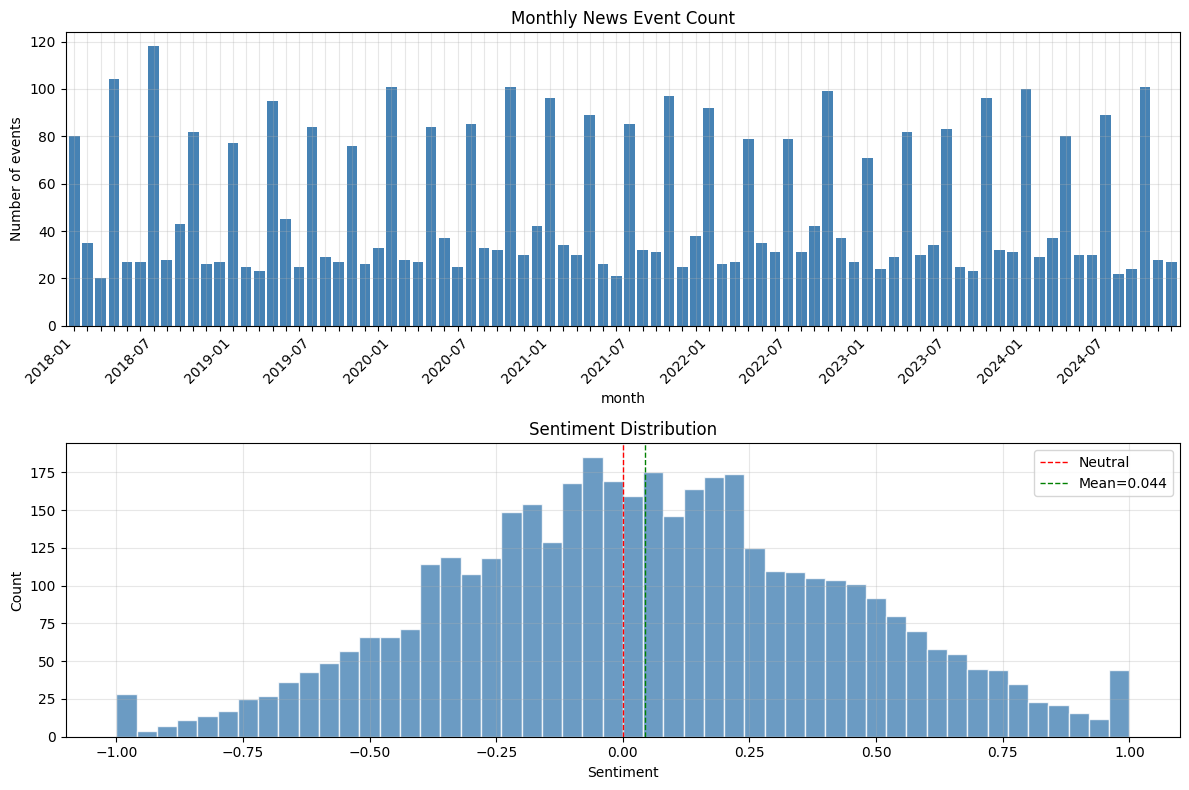

In [3]:
# Plot event frequency over time and sentiment distribution
news_plot = news.copy()
news_plot["month"] = news_plot["timestamp"].dt.to_period("M")
monthly_counts = news_plot.groupby("month").size()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Monthly event count
ax = axes[0]
monthly_counts.plot(kind="bar", ax=ax, color="steelblue", width=0.8)
ax.set_title("Monthly News Event Count")
ax.set_ylabel("Number of events")
# Show every 6th label to avoid crowding
tick_labels = [str(p) if i % 6 == 0 else "" for i, p in enumerate(monthly_counts.index)]
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

# Sentiment histogram
ax2 = axes[1]
ax2.hist(news["sentiment"], bins=50, color="steelblue", edgecolor="white", alpha=0.8)
ax2.axvline(0, color="red", linestyle="--", linewidth=1, label="Neutral")
ax2.axvline(news["sentiment"].mean(), color="green", linestyle="--", linewidth=1,
            label=f"Mean={news['sentiment'].mean():.3f}")
ax2.set_xlabel("Sentiment")
ax2.set_ylabel("Count")
ax2.set_title("Sentiment Distribution")
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Daily aggregation

Raw news events arrive at arbitrary timestamps.  To build a tradeable signal we must
map them to **trading days** with a clear rule for handling after-hours news:

| Event time | Attribution |
|-----------|-------------|
| Before market open (< 09:30) | Same trading day |
| During market hours | Same trading day |
| After market close (>= 16:00) | **Next** trading day |
| Weekend / holiday | Next trading day |

The daily signal for each ticker is the sum of `sentiment x magnitude` for all
events attributed to that day.  Days with no events receive a value of zero.

In [4]:
def aggregate_news_daily(news_df, trading_dates):
    """Aggregate news events to daily (date, ticker) signals.

    After-hours events (>= 16:00) are attributed to the next trading day.
    Weekend/holiday events are attributed to the next trading day.

    Parameters
    ----------
    news_df : DataFrame
        Must have columns: timestamp, ticker, sentiment, magnitude.
    trading_dates : DatetimeIndex
        Sorted trading calendar dates.

    Returns
    -------
    daily_agg : DataFrame
        Columns: date, ticker, impact, n_events, avg_sentiment, avg_magnitude
    """
    df = news_df.copy()

    # Determine raw date and whether event is after-hours
    df["raw_date"] = df["timestamp"].dt.normalize()
    df["hour"] = df["timestamp"].dt.hour
    # After-hours events (>= 16:00) get pushed to next calendar day
    after_hours_mask = df["hour"] >= 16
    df.loc[after_hours_mask, "raw_date"] = df.loc[after_hours_mask, "raw_date"] + pd.Timedelta(days=1)

    # Map each raw_date to the next available trading day
    td_arr = trading_dates.values

    def next_trading_day(dt):
        mask = td_arr >= dt
        if mask.any():
            return pd.Timestamp(td_arr[mask][0])
        return pd.NaT

    unique_raw = df["raw_date"].unique()
    date_map = {d: next_trading_day(d) for d in unique_raw}
    df["trade_date"] = df["raw_date"].map(date_map)
    df = df.dropna(subset=["trade_date"])

    # Compute impact = sentiment x magnitude
    df["impact"] = df["sentiment"] * df["magnitude"]

    # Aggregate per (trade_date, ticker)
    agg = df.groupby(["trade_date", "ticker"]).agg(
        impact=("impact", "sum"),
        n_events=("impact", "size"),
        avg_sentiment=("sentiment", "mean"),
        avg_magnitude=("magnitude", "mean"),
    ).reset_index()
    agg.rename(columns={"trade_date": "date"}, inplace=True)

    return agg

daily_news = aggregate_news_daily(news, trading_dates)
print(f"Daily aggregated rows: {len(daily_news):,}")
print(f"Unique dates with news: {daily_news['date'].nunique()}")
print(f"Unique tickers with news: {daily_news['ticker'].nunique()}")

# Coverage: what fraction of (date, ticker) pairs have news?
total_possible = len(trading_dates) * len(TICKERS)
coverage = len(daily_news) / total_possible
print(f"\nCoverage: {len(daily_news):,} / {total_possible:,} = {coverage:.1%}")
print(f"Average events per day-ticker (when present): {daily_news['n_events'].mean():.2f}")
print(f"\nImpact statistics:")
print(daily_news["impact"].describe().to_string())

Daily aggregated rows: 3,681
Unique dates with news: 1368
Unique tickers with news: 20

Coverage: 3,681 / 35,200 = 10.5%
Average events per day-ticker (when present): 1.13

Impact statistics:
count    3681.000000
mean        0.015696
std         0.136280
min        -0.868180
25%        -0.046764
50%         0.007889
75%         0.080647
max         0.692955


In [5]:
# Convert daily_news to a stacked Series with MultiIndex (date, ticker)
daily_impact = daily_news.set_index(["date", "ticker"])["impact"]
daily_impact = daily_impact.sort_index()

# Build a full panel: fill missing (date, ticker) with 0
full_idx = pd.MultiIndex.from_product(
    [trading_dates, TICKERS], names=["date", "ticker"]
)
news_signal_raw = daily_impact.reindex(full_idx).fillna(0.0)
news_signal_raw.name = "news_impact"

print(f"Full panel shape: {len(news_signal_raw):,} observations")
print(f"Non-zero fraction: {(news_signal_raw != 0).mean():.3%}")
print(f"\nDaily cross-sectional stats (of the raw impact):")
daily_cs = news_signal_raw.groupby(level="date").agg(["mean", "std", "min", "max"])
print(daily_cs.describe().round(4).to_string())

Full panel shape: 35,200 observations
Non-zero fraction: 10.457%

Daily cross-sectional stats (of the raw impact):
            mean        std        min        max
count  1760.0000  1760.0000  1760.0000  1760.0000
mean      0.0016     0.0297    -0.0624     0.0796
std       0.0101     0.0329     0.1002     0.1102
min      -0.0351     0.0000    -0.8682     0.0000
25%      -0.0020     0.0019    -0.0943     0.0000
50%       0.0000     0.0203    -0.0124     0.0263
75%       0.0051     0.0461     0.0000     0.1308
max       0.0687     0.2521     0.0000     0.6930


## 4. Event study

An **event study** measures average abnormal returns around news events.  We define:

$$\text{Abnormal Return}_t = r_{i,t} - \bar{r}_{\text{mkt},t}$$

where the market return is the equal-weight average across all tickers.

We examine a window of **[-5, +10]** days around each event, split by positive
vs negative sentiment.

In [6]:
def event_study(news_df, returns, trading_dates, pre=5, post=10, min_events=30):
    """Compute average abnormal returns around news events.

    Parameters
    ----------
    news_df : DataFrame
        Daily aggregated news with columns: date, ticker, avg_sentiment.
    returns : Series
        Daily returns with MultiIndex (date, ticker).
    trading_dates : DatetimeIndex
        Sorted trading calendar.
    pre, post : int
        Number of days before/after the event.
    min_events : int
        Minimum events per bucket to include.

    Returns
    -------
    result : dict with keys 'positive' and 'negative', each a DataFrame
             with columns: offset, mean_ar, std_ar, count, se
    """
    # Compute market return (equal-weight average each day)
    mkt_ret = returns.groupby(level="date").mean()

    # Abnormal returns
    dates_idx = returns.index.get_level_values("date")
    abnormal = returns - mkt_ret.reindex(dates_idx).values

    # Build a date-to-integer position map for fast offset lookup
    date_to_pos = {d: i for i, d in enumerate(trading_dates)}
    n_dates = len(trading_dates)

    # Split events into positive and negative sentiment
    pos_events = news_df[news_df["avg_sentiment"] > 0][["date", "ticker"]].values
    neg_events = news_df[news_df["avg_sentiment"] < 0][["date", "ticker"]].values

    offsets = list(range(-pre, post + 1))
    result = {}

    for label, events in [("positive", pos_events), ("negative", neg_events)]:
        ar_by_offset = {o: [] for o in offsets}

        for event_date, ticker in events:
            if event_date not in date_to_pos:
                continue
            event_pos = date_to_pos[event_date]

            for offset in offsets:
                target_pos = event_pos + offset
                if 0 <= target_pos < n_dates:
                    target_date = trading_dates[target_pos]
                    key = (target_date, ticker)
                    if key in abnormal.index:
                        ar_by_offset[offset].append(abnormal.loc[key])

        rows = []
        for o in offsets:
            vals = ar_by_offset[o]
            if len(vals) >= min_events:
                arr = np.array(vals)
                rows.append({
                    "offset": o,
                    "mean_ar": arr.mean(),
                    "std_ar": arr.std(),
                    "count": len(arr),
                    "se": arr.std() / np.sqrt(len(arr)),
                })
        result[label] = pd.DataFrame(rows)

    return result

# Run event study
event_result = event_study(daily_news, ret.dropna(), trading_dates, pre=5, post=10)

for label in ["positive", "negative"]:
    df_es = event_result[label]
    print(f"\n{label.upper()} sentiment events:")
    print(f"  Events per offset: {df_es['count'].mean():.0f} (avg)")
    day0 = df_es.loc[df_es['offset'] == 0, 'mean_ar'].values
    if len(day0) > 0:
        print(f"  Day 0 mean abnormal return: {day0[0]*100:.4f}%")
    day1 = df_es.loc[df_es['offset'] == 1, 'mean_ar'].values
    if len(day1) > 0:
        print(f"  Day +1 mean abnormal return: {day1[0]*100:.4f}%")


POSITIVE sentiment events:
  Events per offset: 1979 (avg)
  Day 0 mean abnormal return: -0.0566%
  Day +1 mean abnormal return: 0.0204%

NEGATIVE sentiment events:
  Events per offset: 1695 (avg)
  Day 0 mean abnormal return: -0.0248%
  Day +1 mean abnormal return: -0.0286%


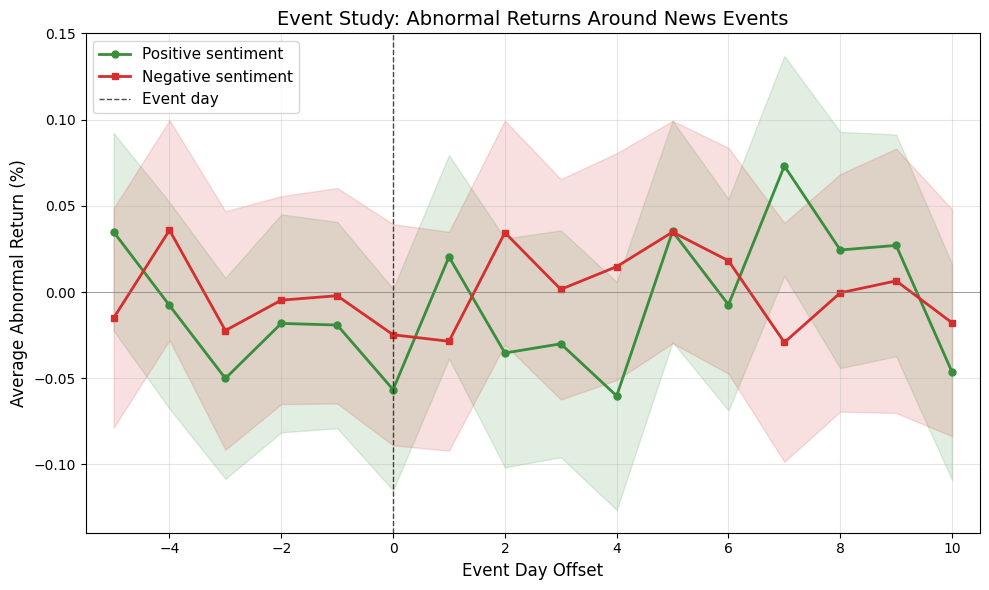

In [7]:
# Plot event study results
fig, ax = plt.subplots(figsize=(10, 6))

for label, color, marker in [("positive", "#388e3c", "o"), ("negative", "#d32f2f", "s")]:
    df_es = event_result[label]
    ax.plot(df_es["offset"], df_es["mean_ar"] * 100, color=color, marker=marker,
            linewidth=2, markersize=5, label=f"{label.capitalize()} sentiment")
    ax.fill_between(df_es["offset"],
                    (df_es["mean_ar"] - 1.96 * df_es["se"]) * 100,
                    (df_es["mean_ar"] + 1.96 * df_es["se"]) * 100,
                    alpha=0.15, color=color)

ax.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.7, label="Event day")
ax.axhline(0, color="grey", linestyle="-", linewidth=0.5)
ax.set_xlabel("Event Day Offset", fontsize=12)
ax.set_ylabel("Average Abnormal Return (%)", fontsize=12)
ax.set_title("Event Study: Abnormal Returns Around News Events", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlim(-5.5, 10.5)
plt.tight_layout()
plt.show()

## 5. Decay functions

News impact does not last forever.  We model information decay with an
**exponential kernel**:

$$s_{i,t}^{\text{decayed}} = \sum_{k=0}^{K} \exp\!\left(-\frac{\ln 2}{\tau} \cdot k\right) \cdot x_{i,t-k}$$

where $\tau$ is the half-life in days and $K$ is the maximum lag.

This creates a smoother, more continuous signal from the sparse raw events.

In [8]:
def apply_decay(signal, halflife=5, max_lag=21):
    """Apply exponential decay to a sparse event signal.

    Parameters
    ----------
    signal : Series
        MultiIndex (date, ticker) signal — typically sparse (many zeros).
    halflife : int
        Number of days for the signal to decay to half its original value.
    max_lag : int
        Maximum number of past days to include in the decay sum.

    Returns
    -------
    Series
        Decayed signal with the same index.
    """
    decay_rate = np.log(2) / halflife
    decay_weights = np.exp(-decay_rate * np.arange(max_lag + 1))

    # Unstack to wide form for vectorised computation
    wide = signal.unstack("ticker")
    result = pd.DataFrame(0.0, index=wide.index, columns=wide.columns)

    for lag in range(max_lag + 1):
        shifted = wide.shift(lag).fillna(0.0)
        result += decay_weights[lag] * shifted

    # Re-stack to (date, ticker) MultiIndex
    stacked = result.stack()
    stacked.index.names = ["date", "ticker"]
    stacked.name = "news_decayed"
    return stacked

# Apply decay with halflife=5, max_lag=21
news_decayed = apply_decay(news_signal_raw, halflife=5, max_lag=21)

# Compare coverage
raw_nonzero = (news_signal_raw != 0).mean()
decayed_nonzero = (news_decayed.abs() > 1e-8).mean()
print(f"Raw signal non-zero fraction:     {raw_nonzero:.3%}")
print(f"Decayed signal non-zero fraction:  {decayed_nonzero:.3%}")
print(f"Coverage amplification:            {decayed_nonzero / max(raw_nonzero, 1e-10):.1f}x")

print(f"\nDecayed signal statistics:")
print(news_decayed.describe().to_string())

Raw signal non-zero fraction:     10.457%
Decayed signal non-zero fraction:  87.182%
Coverage amplification:            8.3x

Decayed signal statistics:
count    35200.000000
mean         0.012031
std          0.089121
min         -0.868180
25%         -0.013850
50%          0.000000
75%          0.034919
max          0.822546


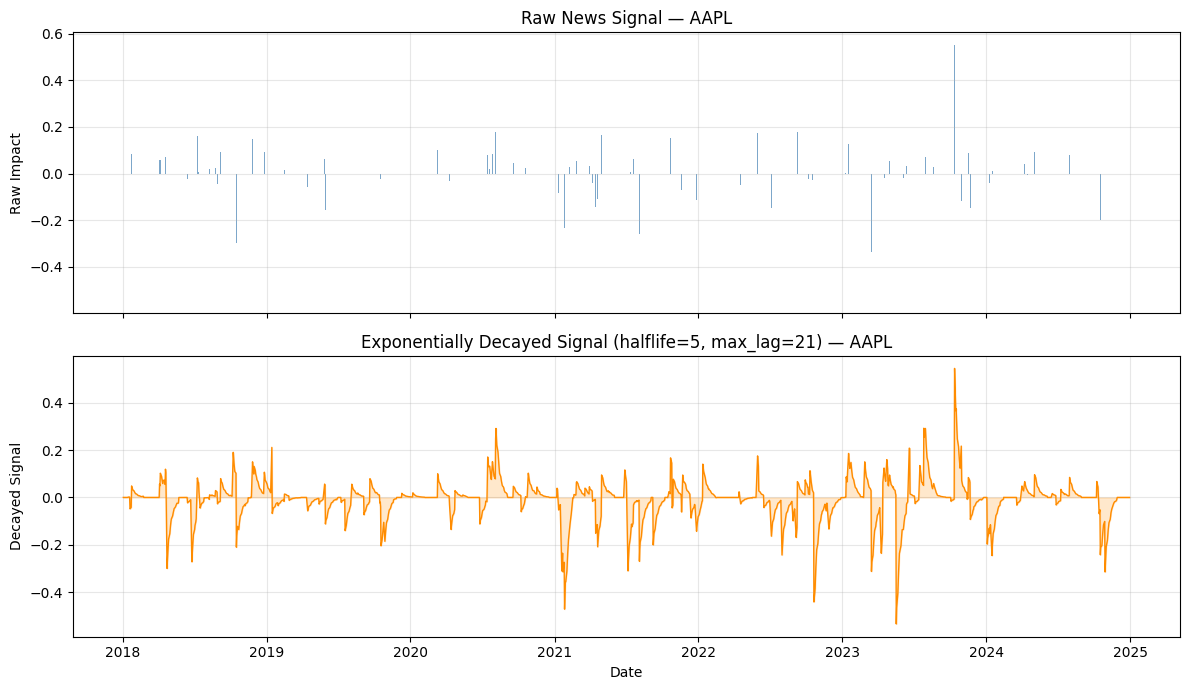

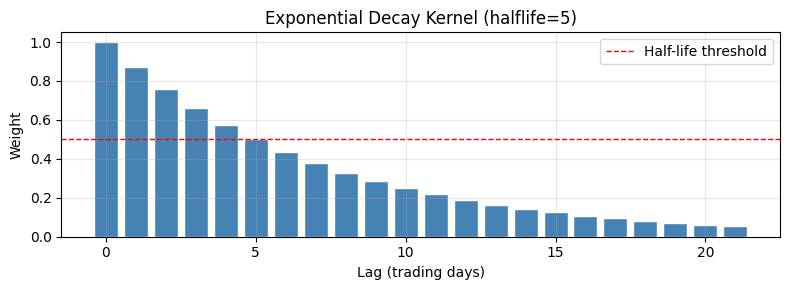

In [9]:
# Plot raw vs decayed signal for a sample ticker
sample_ticker = "AAPL"
raw_ts = news_signal_raw.xs(sample_ticker, level="ticker")
decayed_ts = news_decayed.xs(sample_ticker, level="ticker")

fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax1 = axes[0]
ax1.bar(raw_ts.index, raw_ts.values, width=1, color="steelblue", alpha=0.7)
ax1.set_ylabel("Raw Impact")
ax1.set_title(f"Raw News Signal — {sample_ticker}")

ax2 = axes[1]
ax2.plot(decayed_ts.index, decayed_ts.values, color="darkorange", linewidth=1)
ax2.fill_between(decayed_ts.index, decayed_ts.values, 0, alpha=0.2, color="darkorange")
ax2.set_ylabel("Decayed Signal")
ax2.set_title(f"Exponentially Decayed Signal (halflife=5, max_lag=21) — {sample_ticker}")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

# Show decay kernel
lags = np.arange(22)
kernel = np.exp(-np.log(2) / 5 * lags)
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(lags, kernel, color="steelblue", edgecolor="white")
ax.set_xlabel("Lag (trading days)")
ax.set_ylabel("Weight")
ax.set_title("Exponential Decay Kernel (halflife=5)")
ax.axhline(0.5, color="red", linestyle="--", linewidth=1, label="Half-life threshold")
ax.legend()
plt.tight_layout()
plt.show()

## 6. Three news-based strategies

We build three strategies from the decayed news signal, each exploiting a
different hypothesis about how news affects prices:

| Strategy | Hypothesis | Signal |
|----------|-----------|--------|
| **News momentum** | Positive news leads to continued outperformance | `+decayed_signal` |
| **News reversal** | Markets overreact to news | `-decayed_signal` |
| **Volatility avoidance** | High news activity = high uncertainty = bad | `-abs(decayed_signal)` |

All use **weekly rebalancing** with standard transaction costs.

In [10]:
# Cross-sectional normalisation of the decayed signal
news_cs = zscore(news_decayed)

# Helper function to build weights and run backtest
def run_news_strategy(signal, label, rebalance_freq="weekly"):
    """Build quintile long/short weights from signal and run backtest."""
    sig = signal.replace(0.0, np.nan).dropna()
    # Only keep dates where we have enough non-zero signals for a meaningful sort
    date_counts = sig.groupby(level="date").size()
    valid_dates = date_counts[date_counts >= 4].index
    sig = sig.loc[sig.index.get_level_values("date").isin(valid_dates)]

    if len(sig) == 0:
        print(f"  [{label}] No valid signal dates!")
        return None, None

    weights = equal_weight_long_short(sig, long_pct=0.2, short_pct=0.2)
    weights = normalize_weights(weights, gross_exposure=2.0, net_exposure=0.0)

    config = BacktestConfig(
        rebalance_freq=rebalance_freq,
        commission_bps=5.0,
        slippage_bps=5.0,
        signal_lag=1,
        execution_price="open",
    )
    result = run_backtest(weights, prices, config=config)
    summary = performance_summary(result.portfolio_returns)

    print(f"  [{label}]")
    print(f"    Sharpe:     {summary['sharpe_ratio']:.3f}")
    print(f"    Ann. Ret:   {summary['annualized_return']:.3%}")
    print(f"    Ann. Vol:   {summary['annualized_volatility']:.3%}")
    print(f"    Max DD:     {summary['max_drawdown']:.3%}")
    print(f"    Hit rate:   {summary['hit_rate']:.3%}")
    return result, summary

print("Strategy backtests (weekly rebalance, 5bps cost each side):")
print("=" * 60)

# Strategy 1: News Momentum (long positive sentiment, short negative)
news_mom_sig = news_cs.copy()
result_mom, summary_mom = run_news_strategy(news_mom_sig, "News Momentum")

# Strategy 2: News Reversal (opposite sign)
news_rev_sig = -news_cs.copy()
result_rev, summary_rev = run_news_strategy(news_rev_sig, "News Reversal")

# Strategy 3: Volatility Avoidance (negative of absolute magnitude activity)
news_vol_sig = -news_cs.abs()
news_vol_sig_z = zscore(news_vol_sig.replace(0.0, np.nan).dropna())
result_vol, summary_vol = run_news_strategy(news_vol_sig_z, "Vol Avoidance")

Strategy backtests (weekly rebalance, 5bps cost each side):
  [News Momentum]
    Sharpe:     -0.577
    Ann. Ret:   -8.987%
    Ann. Vol:   15.580%
    Max DD:     -54.176%
    Hit rate:   46.307%
  [News Reversal]
    Sharpe:     -0.684
    Ann. Ret:   -12.024%
    Ann. Vol:   17.587%
    Max DD:     -70.669%
    Hit rate:   49.261%
  [Vol Avoidance]
    Sharpe:     -0.779
    Ann. Ret:   -13.645%
    Ann. Vol:   17.512%
    Max DD:     -69.177%
    Hit rate:   46.932%


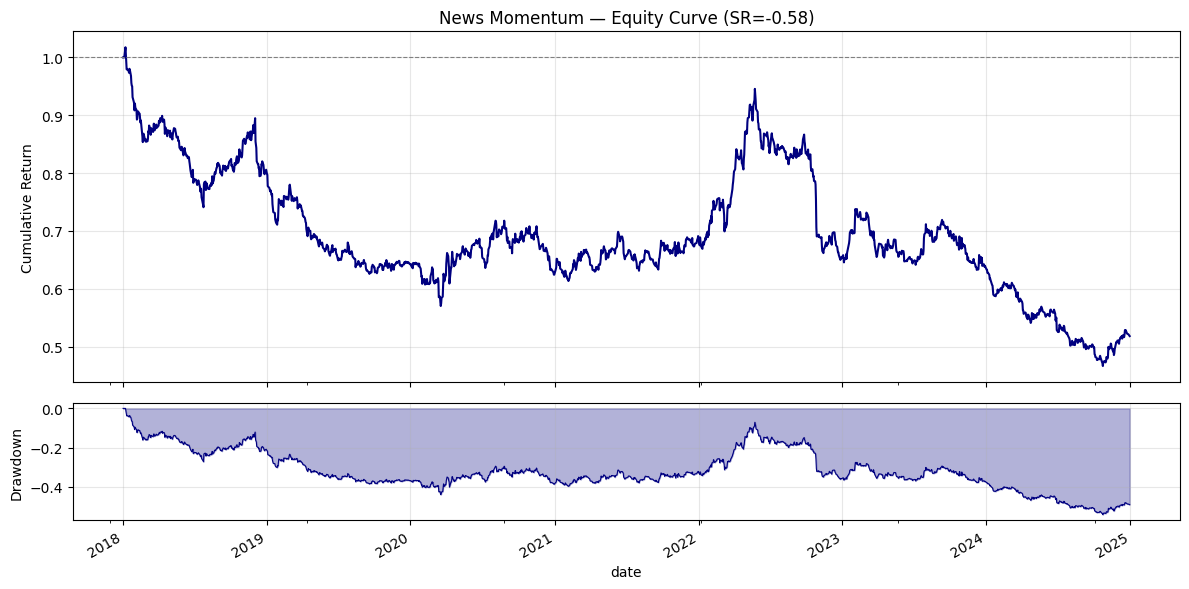

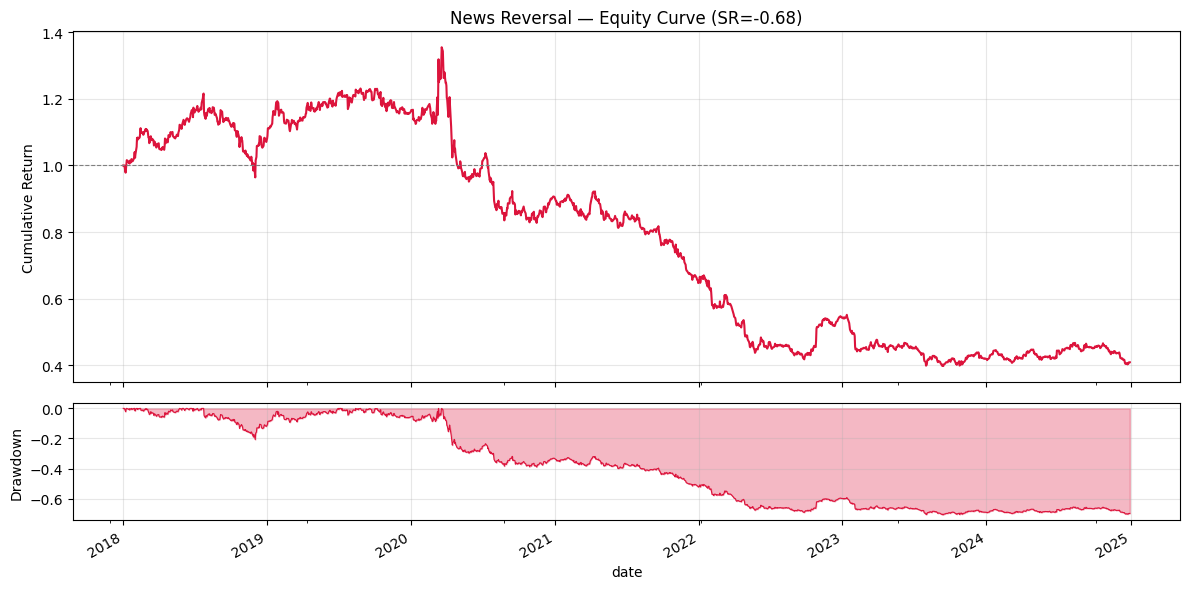

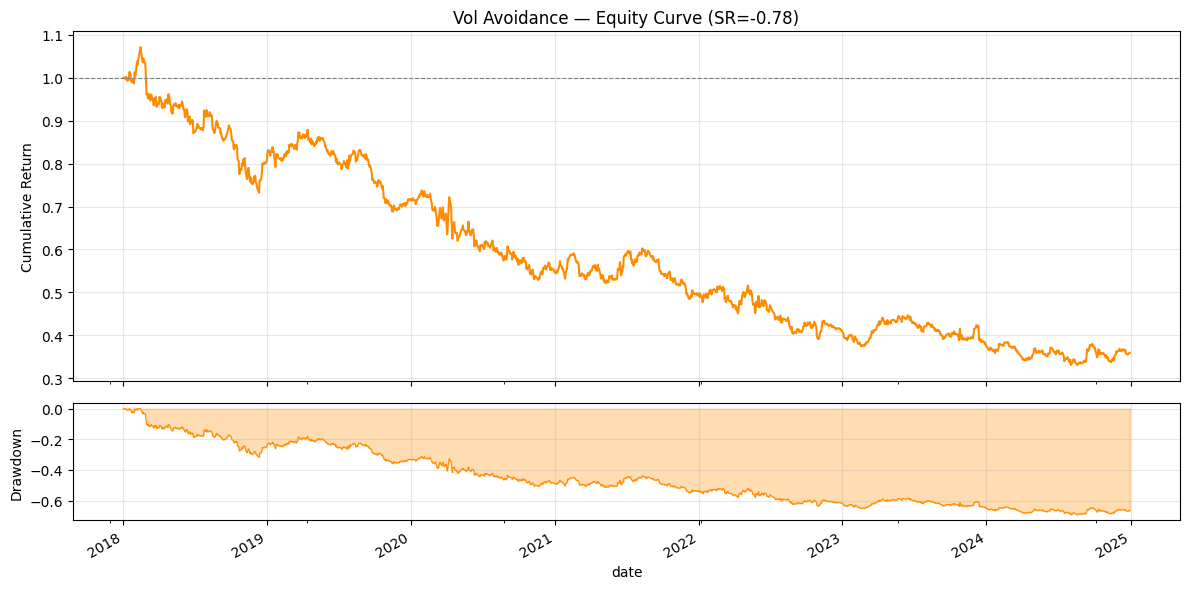

In [11]:
# Individual equity curves with drawdowns
strategies = [
    ("News Momentum", result_mom, summary_mom, "navy"),
    ("News Reversal", result_rev, summary_rev, "crimson"),
    ("Vol Avoidance", result_vol, summary_vol, "darkorange"),
]

for name, result, summary, color in strategies:
    if result is None:
        continue
    cum = (1 + result.portfolio_returns).cumprod()
    dd = drawdown_series(result.portfolio_returns)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                                    gridspec_kw={"height_ratios": [3, 1]})
    cum.plot(ax=ax1, color=color, linewidth=1.5)
    ax1.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
    ax1.set_ylabel("Cumulative Return")
    ax1.set_title(f"{name} — Equity Curve (SR={summary['sharpe_ratio']:.2f})")

    dd.plot(ax=ax2, color=color, linewidth=0.8)
    ax2.fill_between(dd.index, dd.values, 0, alpha=0.3, color=color)
    ax2.set_ylabel("Drawdown")
    plt.tight_layout()
    plt.show()

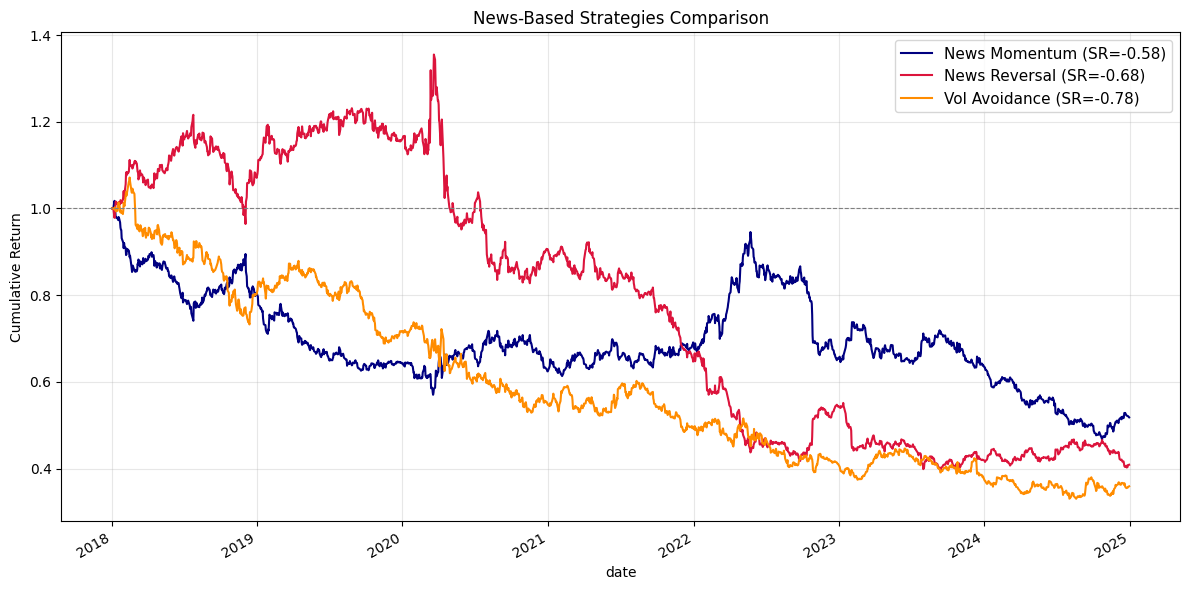

In [12]:
# All 3 equity curves on one chart
fig, ax = plt.subplots(figsize=(12, 6))

for name, result, summary, color in strategies:
    if result is None:
        continue
    cum = (1 + result.portfolio_returns).cumprod()
    sr = summary["sharpe_ratio"]
    cum.plot(ax=ax, color=color, linewidth=1.5, label=f"{name} (SR={sr:.2f})")

ax.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax.set_ylabel("Cumulative Return")
ax.set_title("News-Based Strategies Comparison")
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 7. Combination with price momentum

News signals can complement price-based signals.  We combine:
- **News momentum** (our decayed sentiment signal)
- **Price momentum** (12-month return, skip most recent month)

The combined signal is a simple equal-weight average of the cross-sectionally
normalised components.  If the two signals capture different information, the
blend should have a **higher Sharpe ratio** and **lower drawdown** than either
alone.

In [13]:
# Price momentum signal: 252-day return, skip 21 days
# (12-minus-1 momentum: return over months 2-12)
mom_252 = simple_returns(close, periods=252)
mom_21 = simple_returns(close, periods=21)
price_mom_raw = (1 + mom_252) / (1 + mom_21) - 1
price_mom_cs = zscore(price_mom_raw.dropna())

# Align the two signals on their common index
common_idx = news_cs.dropna().index.intersection(price_mom_cs.dropna().index)
print(f"News signal observations:         {len(news_cs.dropna()):,}")
print(f"Price momentum observations:      {len(price_mom_cs.dropna()):,}")
print(f"Common index observations:        {len(common_idx):,}")

# Combined signal: equal-weight blend
news_aligned = news_cs.reindex(common_idx).fillna(0)
price_aligned = price_mom_cs.reindex(common_idx).fillna(0)
combined = 0.5 * news_aligned + 0.5 * price_aligned
combined = zscore(combined.dropna())

# Backtest all three on the common index
print("\nIndividual and combined strategy comparison:")
print("=" * 60)

# News only (on common dates)
result_news_only, summary_news_only = run_news_strategy(
    zscore(news_aligned), "News Only", rebalance_freq="weekly"
)

# Price momentum only (on common dates)
result_price_only, summary_price_only = run_news_strategy(
    zscore(price_aligned), "Price Mom Only", rebalance_freq="weekly"
)

# Combined
result_combo, summary_combo = run_news_strategy(
    combined, "Combined (50/50)", rebalance_freq="weekly"
)

News signal observations:         35,200
Price momentum observations:      30,160
Common index observations:        30,160

Individual and combined strategy comparison:
  [News Only]
    Sharpe:     -0.394
    Ann. Ret:   -5.660%
    Ann. Vol:   14.358%
    Max DD:     -50.690%
    Hit rate:   39.830%
  [Price Mom Only]
    Sharpe:     -0.206
    Ann. Ret:   -4.947%
    Ann. Vol:   24.007%
    Max DD:     -51.661%
    Hit rate:   44.261%
  [Combined (50/50)]
    Sharpe:     -0.237
    Ann. Ret:   -4.668%
    Ann. Vol:   19.696%
    Max DD:     -48.073%
    Hit rate:   42.841%


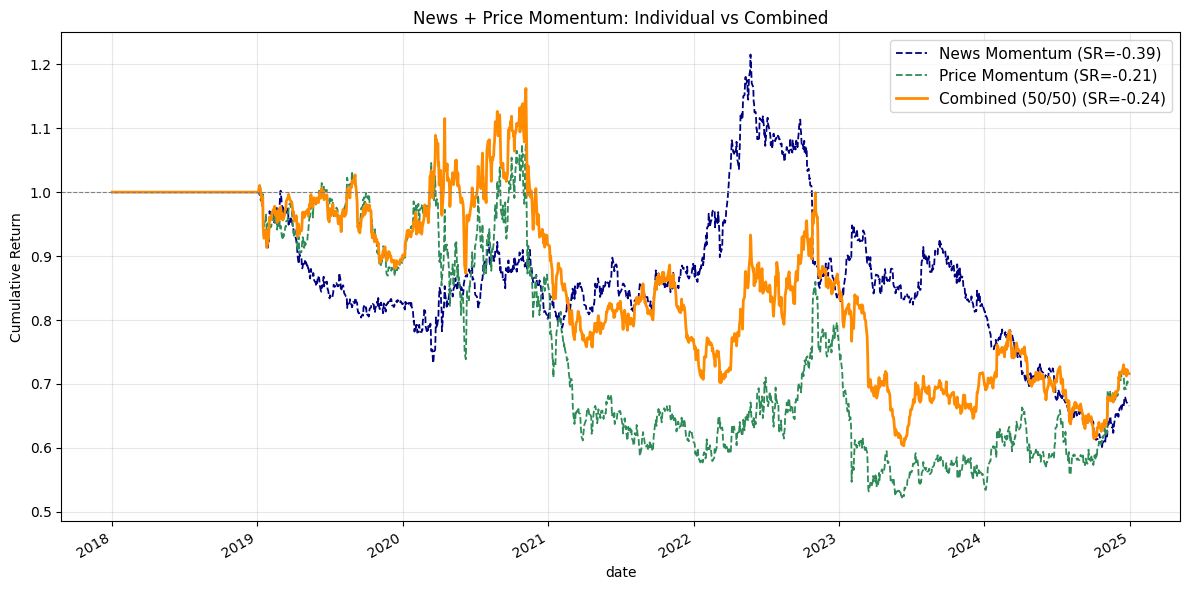


Avg cross-sectional correlation (news vs price momentum): -0.007
Low correlation => diversification benefit from combining.


In [14]:
# Plot combined vs individual equity curves
fig, ax = plt.subplots(figsize=(12, 6))

curve_data = [
    ("News Momentum", result_news_only, summary_news_only, "navy"),
    ("Price Momentum", result_price_only, summary_price_only, "seagreen"),
    ("Combined (50/50)", result_combo, summary_combo, "darkorange"),
]

for name, result, summary, color in curve_data:
    if result is None:
        continue
    cum = (1 + result.portfolio_returns).cumprod()
    sr = summary["sharpe_ratio"]
    lw = 2.0 if "Combined" in name else 1.3
    ls = "-" if "Combined" in name else "--"
    cum.plot(ax=ax, color=color, linewidth=lw, linestyle=ls,
             label=f"{name} (SR={sr:.2f})")

ax.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax.set_ylabel("Cumulative Return")
ax.set_title("News + Price Momentum: Individual vs Combined")
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Cross-signal correlation
sig_corr = news_aligned.groupby(level="date").corr(price_aligned)
print(f"\nAvg cross-sectional correlation (news vs price momentum): {sig_corr.mean():.3f}")
print("Low correlation => diversification benefit from combining.")

## 8. Backtesting considerations for event-driven strategies

Event-driven strategies introduce unique backtesting pitfalls beyond those
in standard cross-sectional factor models.

### 8.1 Lookahead bias

The most dangerous error: using future information in signal construction.

| Timing cutoff | Safe? | Why |
|--------------|-------|-----|
| Event at 14:00, trade at close same day | Possibly | Signal observed before execution |
| Event at 17:00 (after-hours), trade at close same day | **NO** | Signal not yet available |
| Event at 17:00, trade at next day open | Yes | Respects information flow |
| Aggregated daily score using all events from day *t*, trade at close *t* | **NO** | After-hours events included |
| Aggregated daily score using events through 15:59, trade at close *t* | Yes | Cutoff before execution |

Our implementation attributes after-hours events to the next trading day,
and applies a 1-day signal lag on top, providing a conservative buffer.

In [15]:
# Lookahead bias check: verify our timing
news_timing = news.copy()
news_timing["hour"] = news_timing["timestamp"].dt.hour

pre_market = (news_timing["hour"] < 10).sum()
market_hours = ((news_timing["hour"] >= 10) & (news_timing["hour"] < 16)).sum()
after_hours = (news_timing["hour"] >= 16).sum()

print("Timing distribution of news events:")
print(f"  Pre-market (< 10:00):   {pre_market:>5,} ({pre_market/len(news):.1%})")
print(f"  Market hours (10-15):   {market_hours:>5,} ({market_hours/len(news):.1%})")
print(f"  After-hours (>= 16:00): {after_hours:>5,} ({after_hours/len(news):.1%})")
print(f"\nAfter-hours events are pushed to next trading day => no lookahead bias.")
print(f"Signal lag = 1 day => additional buffer for stale data.")

Timing distribution of news events:
  Pre-market (< 10:00):     910 (21.8%)
  Market hours (10-15):   1,805 (43.3%)
  After-hours (>= 16:00): 1,458 (34.9%)

After-hours events are pushed to next trading day => no lookahead bias.
Signal lag = 1 day => additional buffer for stale data.


### 8.2 Event overlap

When multiple events for the same ticker occur on the same day, aggregation
can mask or amplify the true signal.

In [16]:
# Event overlap analysis
events_per_day_ticker = daily_news.groupby(["date", "ticker"])["n_events"].sum()
multi_event = events_per_day_ticker[events_per_day_ticker > 1]
single_event = events_per_day_ticker[events_per_day_ticker == 1]

print("Event overlap statistics:")
print(f"  Total (date, ticker) pairs with news:  {len(events_per_day_ticker):,}")
print(f"  Single-event days:                     {len(single_event):,} ({len(single_event)/len(events_per_day_ticker):.1%})")
print(f"  Multi-event days:                      {len(multi_event):,} ({len(multi_event)/len(events_per_day_ticker):.1%})")
print(f"  Max events in one (date, ticker):      {events_per_day_ticker.max()}")
print(f"\nDistribution of events per (date, ticker):")
print(events_per_day_ticker.value_counts().sort_index().head(10).to_string())

Event overlap statistics:
  Total (date, ticker) pairs with news:  3,681
  Single-event days:                     3,263 (88.6%)
  Multi-event days:                      418 (11.4%)
  Max events in one (date, ticker):      5

Distribution of events per (date, ticker):
n_events
1    3263
2     358
3      48
4      10
5       2


### 8.3 Sparse signals

Unlike price-based factors (which have a value for every stock-day), news
signals are **sparse**: most stock-days have zero events.  This creates challenges:

- **Signal-to-noise ratio**: aggregating across many zero-signal days dilutes
  the true information.
- **Portfolio construction**: on days with only 2-3 non-zero signals, a quintile
  sort is unstable.
- **Turnover**: if events are rare but the rebalance is frequent, positions will
  whipsaw between zero and non-zero.

Our decay function (Section 5) partially addresses this by creating a continuous
signal from discrete events.

### 8.4 Delayed reaction

Markets may not react immediately to news.  Some academic studies find that
the full impact takes 1-3 days to materialise (especially for less-liquid
stocks or complex information).  Our event study in Section 4 provides evidence
on the speed of adjustment.

### 8.5 Survivorship bias

Our universe consists of 20 large-cap stocks that survived through the entire
2018-2024 period.  This introduces **survivorship bias**: stocks that were
delisted or declined significantly are excluded.  In practice, news-based
strategies should use a **point-in-time universe** that includes all stocks
that were tradeable on each historical date.

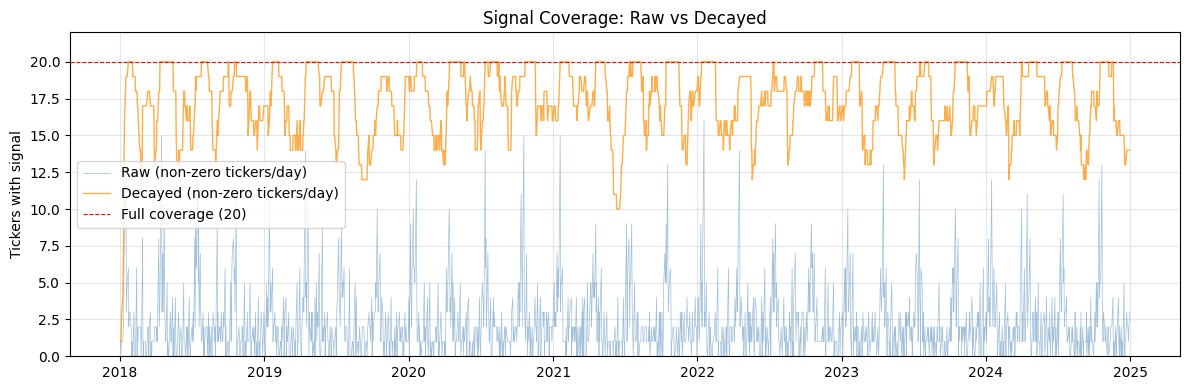

Average tickers with non-zero signal per day:
  Raw:     2.1 / 20
  Decayed: 17.4 / 20


In [17]:
# Sparsity analysis: raw vs decayed signal coverage over time
raw_nonzero_by_date = (news_signal_raw != 0).groupby(level="date").sum()
decayed_nonzero_by_date = (news_decayed.abs() > 1e-8).groupby(level="date").sum()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(raw_nonzero_by_date.index, raw_nonzero_by_date.values,
        alpha=0.5, linewidth=0.5, color="steelblue", label="Raw (non-zero tickers/day)")
ax.plot(decayed_nonzero_by_date.index, decayed_nonzero_by_date.values,
        alpha=0.7, linewidth=1, color="darkorange", label="Decayed (non-zero tickers/day)")
ax.axhline(len(TICKERS), color="red", linestyle="--", linewidth=0.8,
           label=f"Full coverage ({len(TICKERS)})")
ax.set_ylabel("Tickers with signal")
ax.set_title("Signal Coverage: Raw vs Decayed")
ax.legend()
ax.set_ylim(0, len(TICKERS) + 2)
plt.tight_layout()
plt.show()

print(f"Average tickers with non-zero signal per day:")
print(f"  Raw:     {raw_nonzero_by_date.mean():.1f} / {len(TICKERS)}")
print(f"  Decayed: {decayed_nonzero_by_date.mean():.1f} / {len(TICKERS)}")

## 9. Summary

In [18]:
# Build summary table
summary_data = []
all_results = [
    ("News Momentum", summary_mom),
    ("News Reversal", summary_rev),
    ("Vol Avoidance", summary_vol),
    ("Price Momentum", summary_price_only),
    ("Combined (News+Price)", summary_combo),
]

for name, s in all_results:
    if s is not None:
        summary_data.append({
            "Strategy": name,
            "Ann. Return": f"{s['annualized_return']:.2%}",
            "Ann. Vol": f"{s['annualized_volatility']:.2%}",
            "Sharpe": f"{s['sharpe_ratio']:.3f}",
            "Sortino": f"{s['sortino_ratio']:.3f}",
            "Max DD": f"{s['max_drawdown']:.2%}",
            "Calmar": f"{s['calmar_ratio']:.3f}",
            "Hit Rate": f"{s['hit_rate']:.2%}",
        })

summary_table = pd.DataFrame(summary_data)
print(summary_table.to_string(index=False))

             Strategy Ann. Return Ann. Vol Sharpe Sortino  Max DD Calmar Hit Rate
        News Momentum      -8.99%   15.58% -0.577  -0.853 -54.18% -0.166   46.31%
        News Reversal     -12.02%   17.59% -0.684  -0.945 -70.67% -0.170   49.26%
        Vol Avoidance     -13.64%   17.51% -0.779  -1.142 -69.18% -0.197   46.93%
       Price Momentum      -4.95%   24.01% -0.206  -0.244 -51.66% -0.096   44.26%
Combined (News+Price)      -4.67%   19.70% -0.237  -0.299 -48.07% -0.097   42.84%


## Key takeaways

| Concept | Key takeaway |
|---------|-------------|
| News data | Discrete, irregular, sparse -- fundamentally different from price data |
| Aggregation | After-hours attribution and daily summing are critical for avoiding lookahead |
| Event study | Validates whether news has predictive content before building strategies |
| Decay | Converts sparse events into continuous signals; half-life is a key parameter |
| Strategies | Momentum, reversal, and volatility avoidance exploit different mechanisms |
| Combination | Blending news with price signals can improve risk-adjusted returns |
| Pitfalls | Lookahead bias, sparsity, event overlap, survivorship bias all require care |

**Next**: Tutorial 7 explores multi-horizon signal blending and regime detection.